<a href="https://colab.research.google.com/github/serdarbozoglan/01_Computer_Vision/blob/master/PyTorch07_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision
import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
# First we convert images to Tensors
# Then we normalize the values between [-1, 1]
# first (0.5, 0.5, 0.5) mean of channel, height, width and second ones are std dev for each one 
# Normalize ederken sadece (0.5), (0.5) uygalamaizin nedeni gray scale oldugu icin
# Eger 3 color olsydi (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) uygulayacaktik
transform = T.Compose([T.Resize((28,28)),
                               T.ToTensor(),
                               T.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [0]:
# numpy array a cevirecegiz simdi de
# dimension [channels, height, width]
# PLOTLAMAK ICIN [HEIGHT WIDTH CHANNELS] formatinda olmali
# [1, 28, 28] olan format [28, 28, 1] formatinda olmali

def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

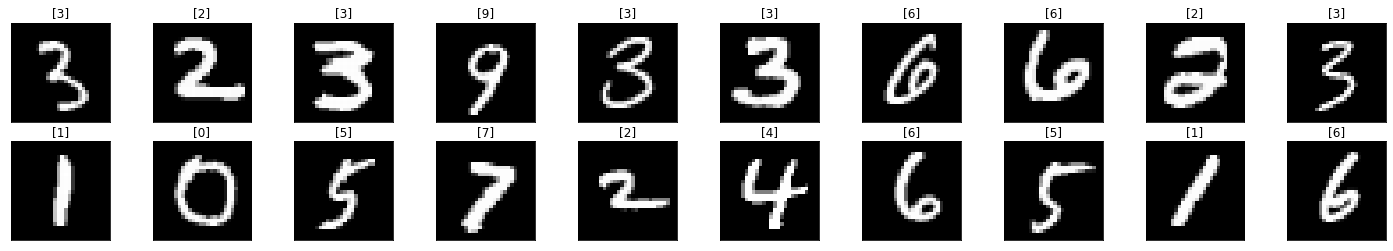

In [33]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
plt.show();

In [0]:

class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(1, 20, 5, 1)
      self.conv2 = nn.Conv2d(20, 50, 5, 1)
      self.fc1 = nn.Linear(4*4*50, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [23]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [25]:
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #outputs = model(inputs)
    print(inputs.shape)
    break


torch.Size([100, 1, 28, 28])


In [37]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

RuntimeError: ignored

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='val_training loss')
plt.legend();

In [0]:
def plot_accuracy_and_loss(history, title):

    plt.figure(1, figsize=(15,10))

    # Accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    #plt.plot(history.history['val_categorical_accuracy'])
    plt.title(title+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='best')

    # Loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
   # plt.plot(history.history['val_loss'])
    plt.title(title+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'test'], loc='best')

### Testing The Model

In [0]:
#!pip install pillow==4.00

In [0]:
from PIL import Image
import cv2

img = cv2.imread('number2.jpg')
plt.imshow(img);

In [0]:
# The above image does not show the RGB but BGR format so convert into original color
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

### Preprocessing

In [0]:
# We need to convert into gray scale
# Bunun icin tekrar okumamiz lazim cunku RGB'edn Gray e donusturemiyoruz but BGR to Gray available
from google.colab.patches import cv2_imshow
%matplotlib inline
img = cv2.imread('number2.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Original image
cv2_imshow(gray)
# showing smaller
plt.imshow(gray, cmap='gray');

In [0]:
gray.shape

In [0]:
### Hala istedigimiz gibi degil, Threshold kullanarak belli bir degerin altini blak sonra white yapacahiz

(thresh, blackAndWhiteImage) = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
plt.imshow(blackAndWhiteImage, cmap='gray');
print ('New Shape is:', blackAndWhiteImage.shape);
# Evet bu istedigimiz format

In [0]:
# Saving image
cv2.imwrite('black2.jpg', blackAndWhiteImage)

In [0]:
!pip install pillow==4.1.1
!pip install --user opencv-contrib-python
%reload_ext autoreload
%autoreload

# COK ONEMLI: 
cv2.imread otomatik olarak 3 color channel olarak okur, gray scale olsa bile, flag'e dikkat et gray scale okurken

In [0]:
from PIL import Image
img = cv2.imread('black2.jpg', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img)
#plt.imshow(img);
print('image shape', img.shape);

In [0]:
# We need to tranform image what we appiled above, resizing etc
from PIL import Image
PIL_image = Image.fromarray(img)
img = transform(PIL_image)
plt.imshow(image_convert(img));

In [0]:
img.shape

In [0]:
img =img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, dim=1)
print(pred.item())
# 3 olarak predict etti HATA

In [0]:
img = cv2.imread('number5.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [0]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
print('shape:', gray.shape);

In [0]:
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage, cmap='gray');
# This is what we want

In [0]:
PIL_image = Image.fromarray(blackAndWhiteImage)
img = transform(PIL_image)
plt.imshow(image_convert(img));

In [0]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, dim=1)
print(pred.item())
# This time correct

### Batch Prediction From Validation Set

In [0]:
data_iter = iter(validation_loader);

# data_iter.next() --> bring us a BATCH of data each time
images, labels = data_iter.next();
images_ = images.view(images.shape[0], -1)# Flatteing the image except color channel
outputs = model(images_)
_, preds = torch.max(outputs, dim=1) 

fig = plt.figure(figsize=(25, 6));

# We ll check 20 images from training set
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1);
    plt.imshow(image_convert(images[idx]));
    # A: Actula P:Predicted
    ax.set_title("A:{} P:{}".format(str(labels[idx].item()), str(preds[idx].item())), color=('green' if preds[idx]==labels[idx] else 'red'));
plt.show();

In [0]:
print('Bismillahirrahmanirrahim')